## UFC Analysis


This notebook in combination with the scripts in the Scripts folder can be used to read+clean data, load it into sql, and query that data.


In [2]:
import pandas as pd
import mysql.connector as sql
import matplotlib.pyplot as plt
from Scripts.queries import query_data

The following query builds a file comparing of Knockout percent in regular vs title bouts by weight class.

In [8]:
df = query_data("""SELECT 
	                weight_class, 
                    COUNT(CASE WHEN finish = "KO/TKO" THEN 1 END) / COUNT(*) * 100 AS KoPct,
                    COUNT(CASE WHEN finish = "KO/TKO" AND title_bout = 1 THEN 1 END) / COUNT(CASE WHEN title_bout = 1 THEN 1 END) * 100 AS KoPct_Title
                FROM ufc_fights WHERE weight_class NOT IN ("Catch Weight") GROUP BY weight_class ORDER BY KoPct;
                """)
df.to_csv("KosTitles.csv")


/Users/brendandesjardins/UFC Project/Scripts/queries.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


### Using the above query, the following visualization was made:

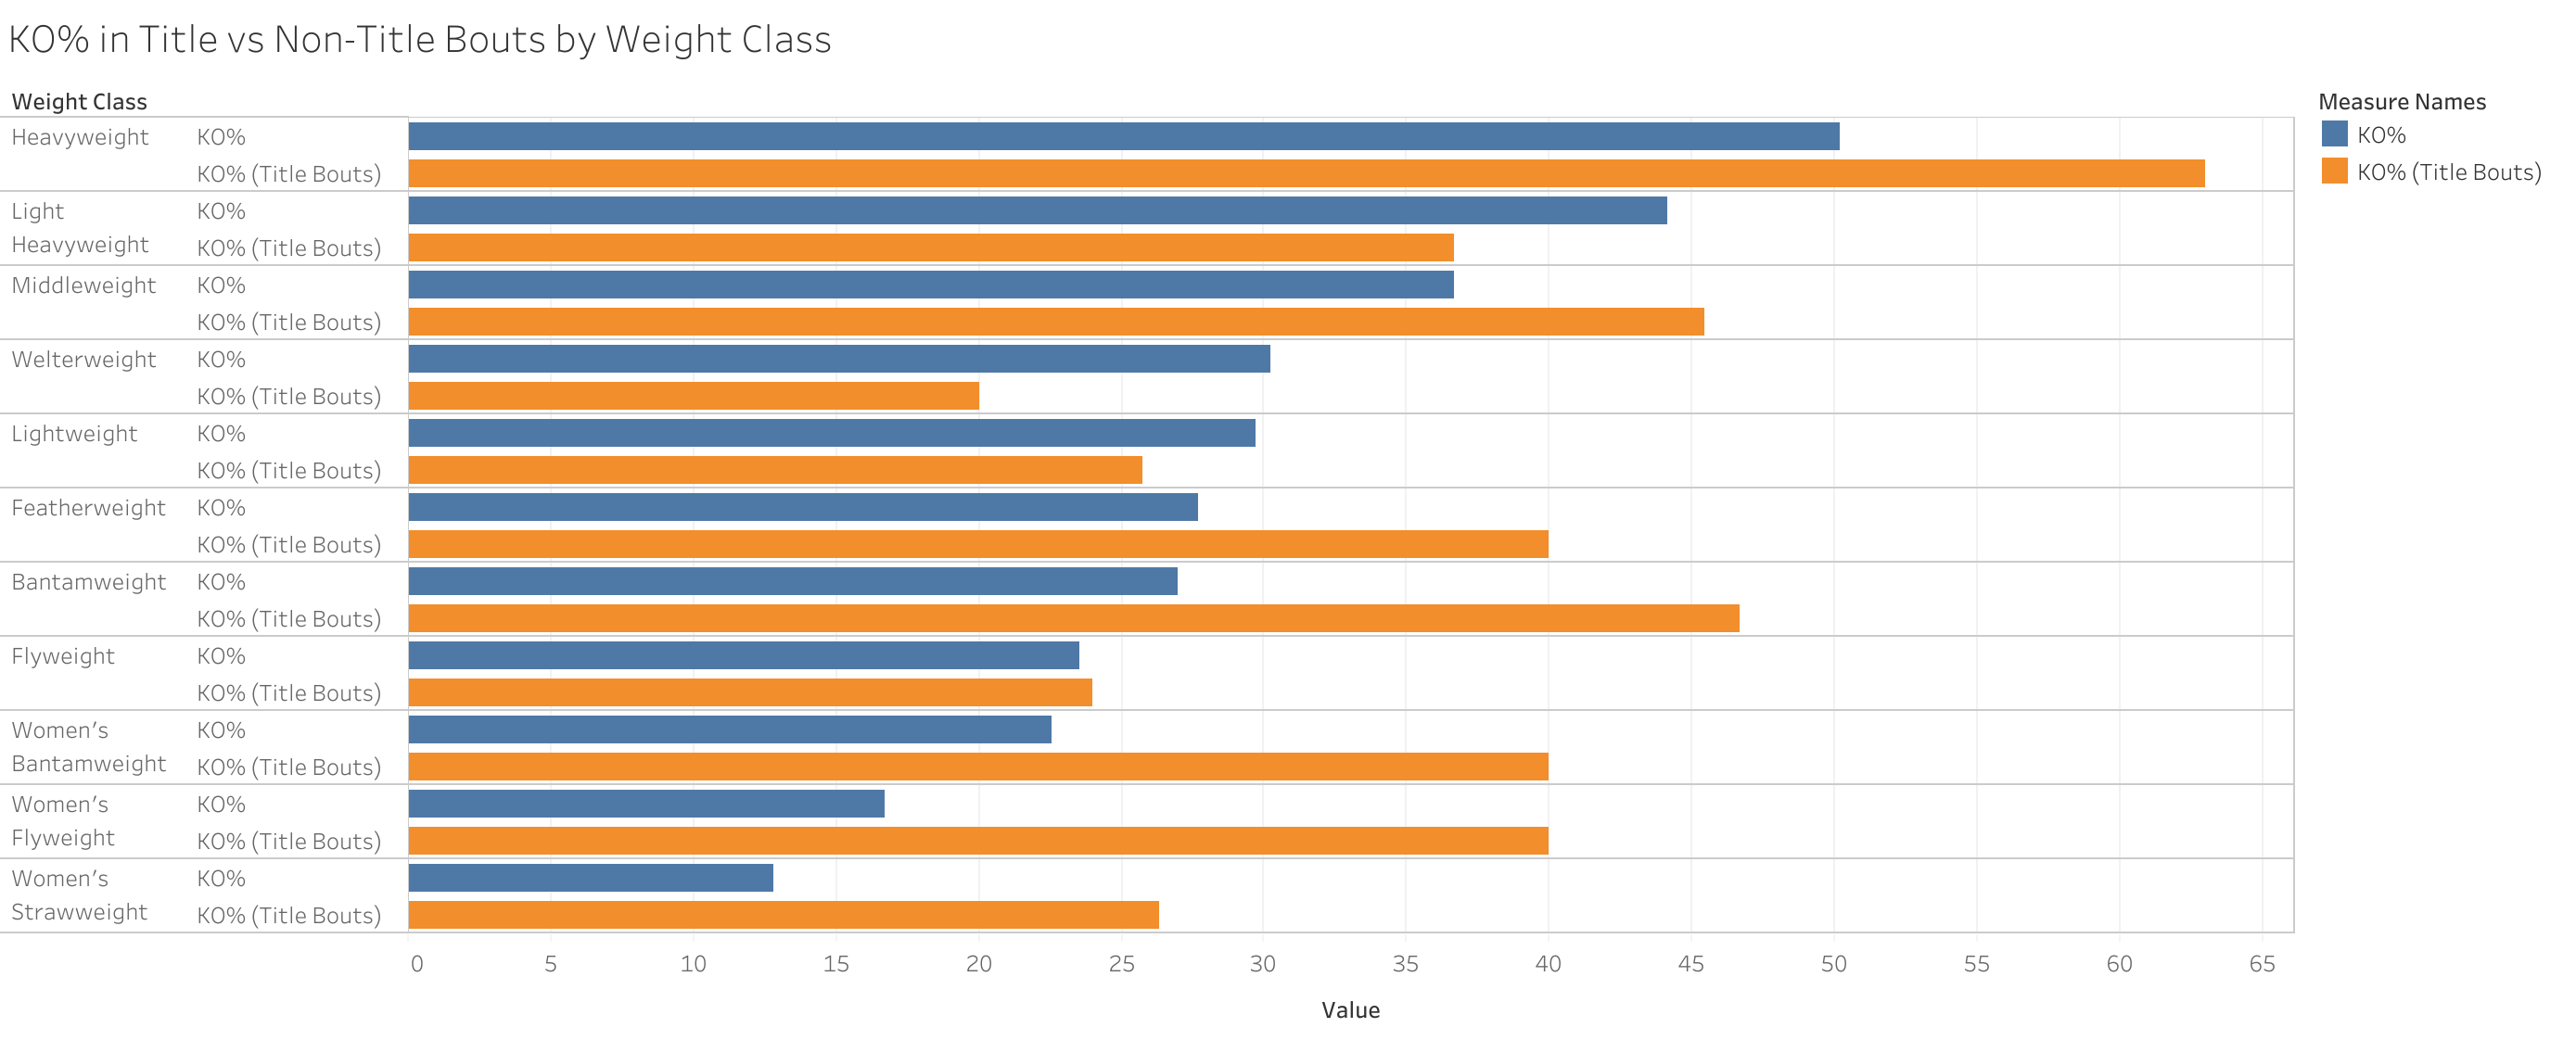

As you can see, the KO%'s in regular bouts are ordered directly in association with wieght class size - higher weight classes have higher KO%. However, in title bouts, we can see that divisions like welterweight and light heavyweight have lower KO%'s, while divisions like bantamweight and heavyweight have much higher KO% in title bouts. 

Knowing UFC history, this can be attributed to the long-reigning champions in these weight classes - welterweight had George St-Pierre and Kamaru Usman, and Light Heavyweight had Jon Jones, all fighters who mostly win fights by decision. However, divisions like bantamweight and light heavyweight have knockout artists such as Francis Ngannou, Cain Velasquez, TJ Dillashaw, and Petr Yan.

This query builds the individual data file that shows each fighters stats

In [8]:
df = query_data("""SELECT 
                         DISTINCT fighter_name, MAX(wins) / (MAX(losses)+MAX(wins)) AS win_loss, 
                         AVG(avg_pct) as avg_pct, 
                         AVG(avg_str) as avg_str,
                         AVG(avg_td) as avg_td,
                         AVG(avg_sub_att) as avg_sub_att,
                         MAX(sub_wins) as sub_wins,
                         MAX(ko_wins)/MAX(wins) as ko_pct 
                    FROM (
	                    SELECT 
                              red_fighter AS fighter_name, 
                              red_wins AS wins, 
                              red_losses as losses, 
                              red_avg_str_pct AS avg_pct, 
                              red_avg_str as avg_str,
                              red_avg_td as avg_td,
                              red_avg_sub_att as avg_sub_att,
                              red_wins_sub as sub_wins,
                              red_wins_ko as ko_wins 
                              FROM ufc_fights
                         UNION ALL
                         SELECT 
                              blue_fighter AS fighter_name, 
                              blue_wins AS wins, 
                              blue_losses as losses,
                              blue_avg_str_pct AS avg_pct, 
                              blue_avg_str as avg_str,
                              blue_avg_td as avg_td,
                              blue_avg_sub_att as avg_sub_att,
                              blue_wins_sub as sub_wins,
                              blue_wins_ko as ko_wins 
                         FROM ufc_fights
                ) AS combined
               GROUP BY fighter_name HAVING MAX(wins)+MAX(losses) >= 5 LIMIT 15000;""")
df.to_csv("Queried-Data/Individual_Averages.csv")

### Using this new dataset of fighter stats, the following visuals were made:

#### Investigating which statistic is most correlated with win percent


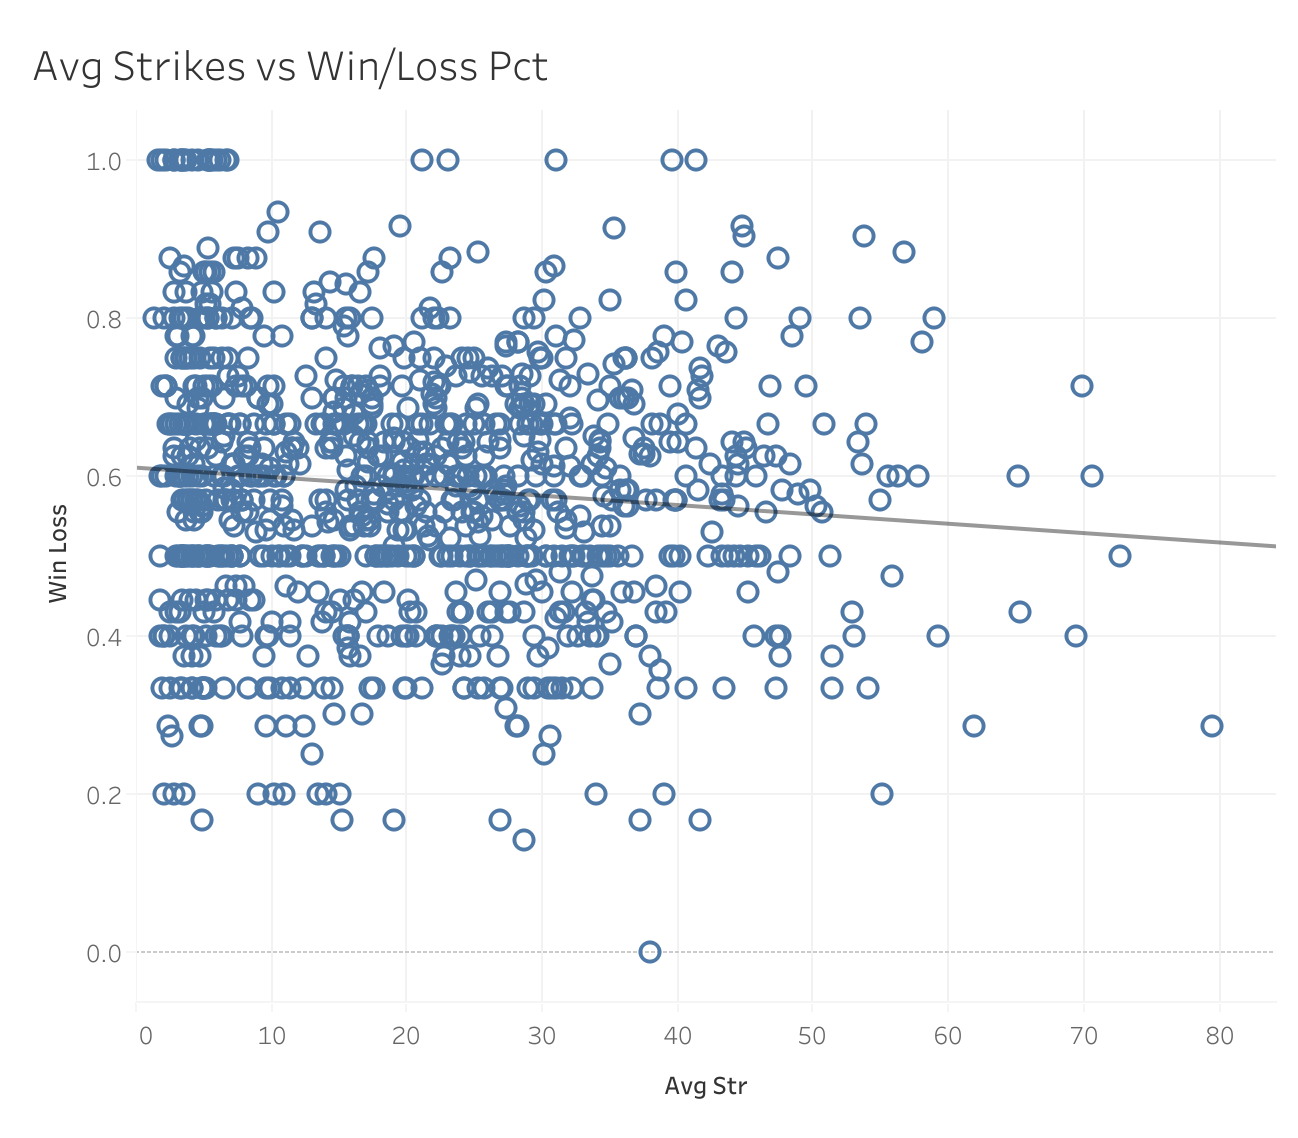
Fighter average strikes landed vs win percentage. As seen, the correlation here is not very strong.

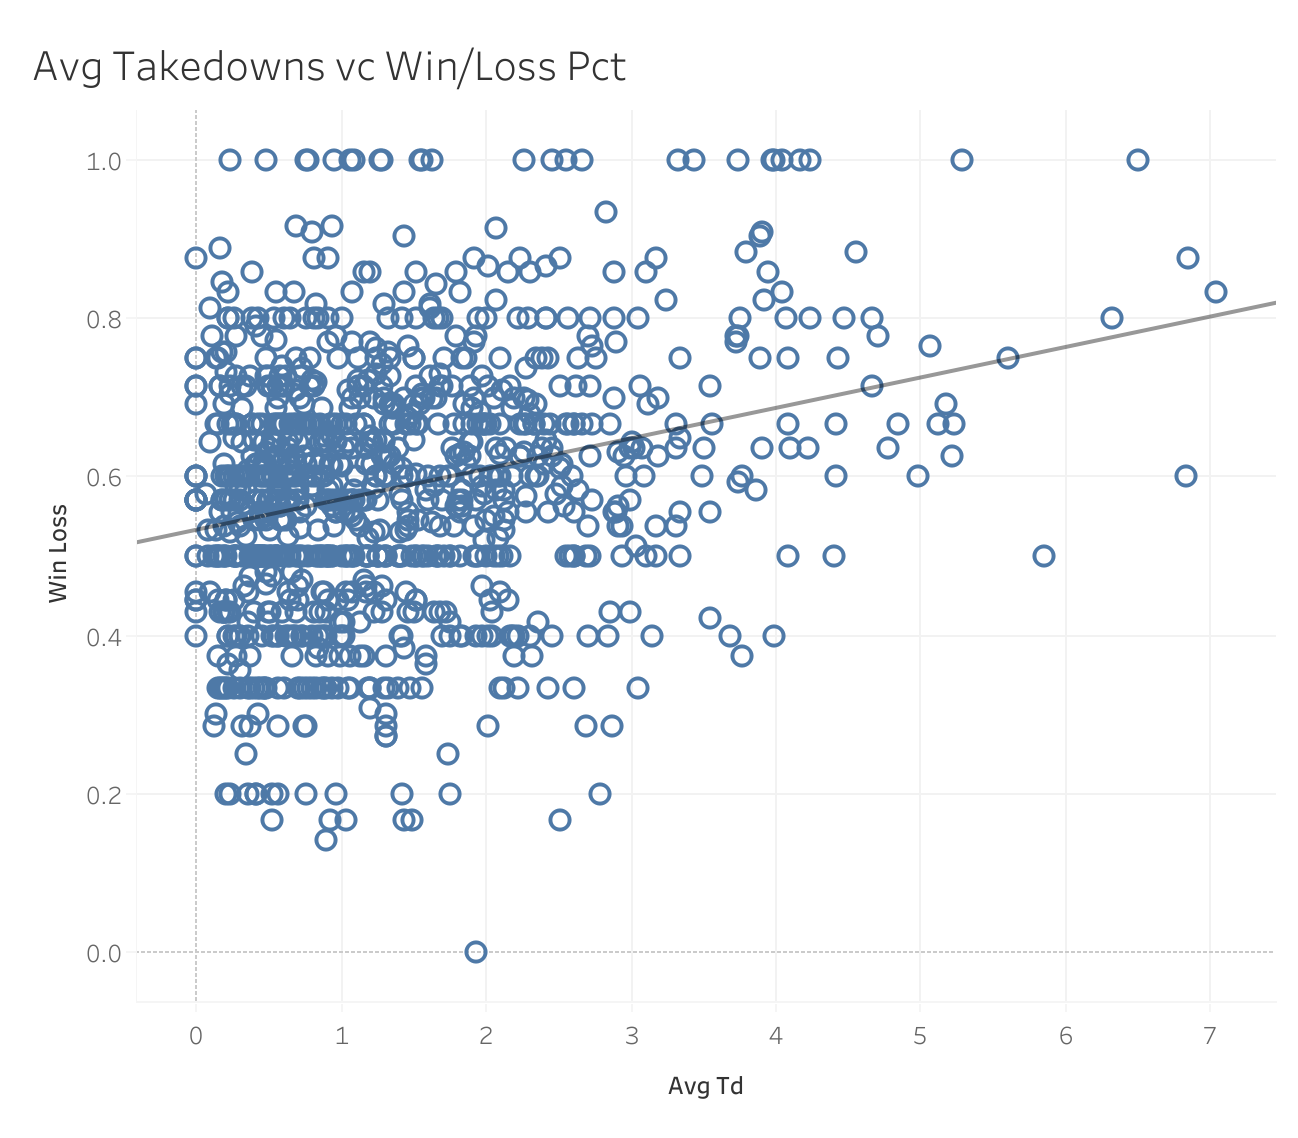
Fighter average takedowns landed vs win percentage. As seen in this, takedowns are more correlated with higher winning percentage.

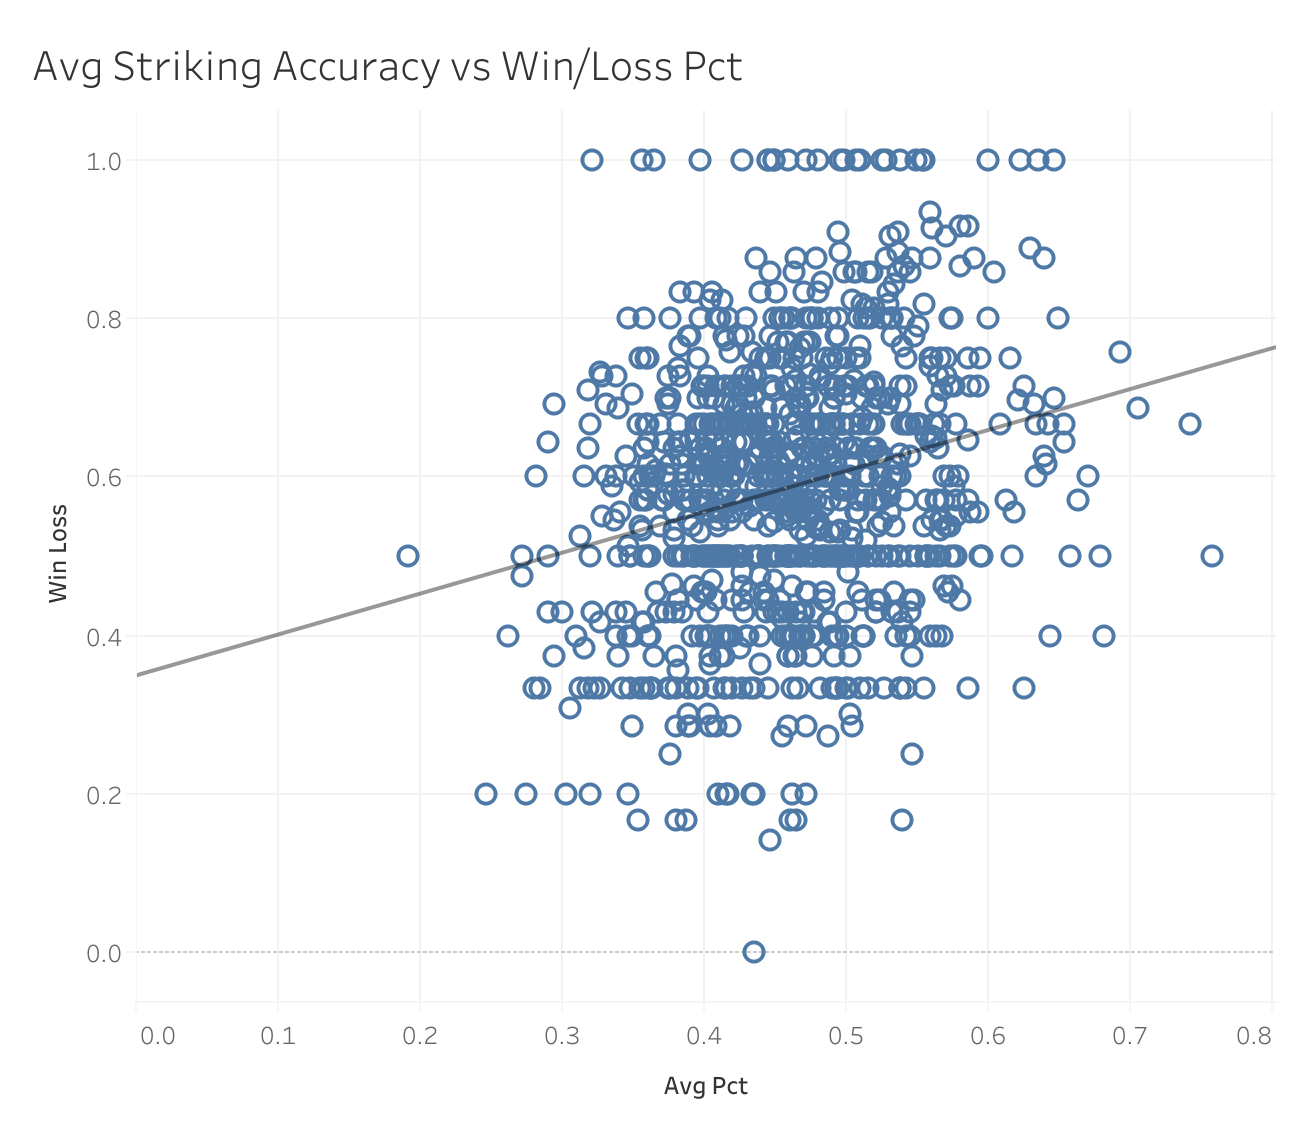
Fighter average striking accuracy vs win percentage. As seen in this, this statistic more accurately correlated with higher winning percentage.


#### Fighter takedown rate vs submission attempt rate

A common complaint that UFC fans have about fighters are fighters who use takedowns extremely often without any intent of submitting their opponent. This graph shows each fighter's takedown average along with submission attempt average, with prominent fighters labeled in the second graph.

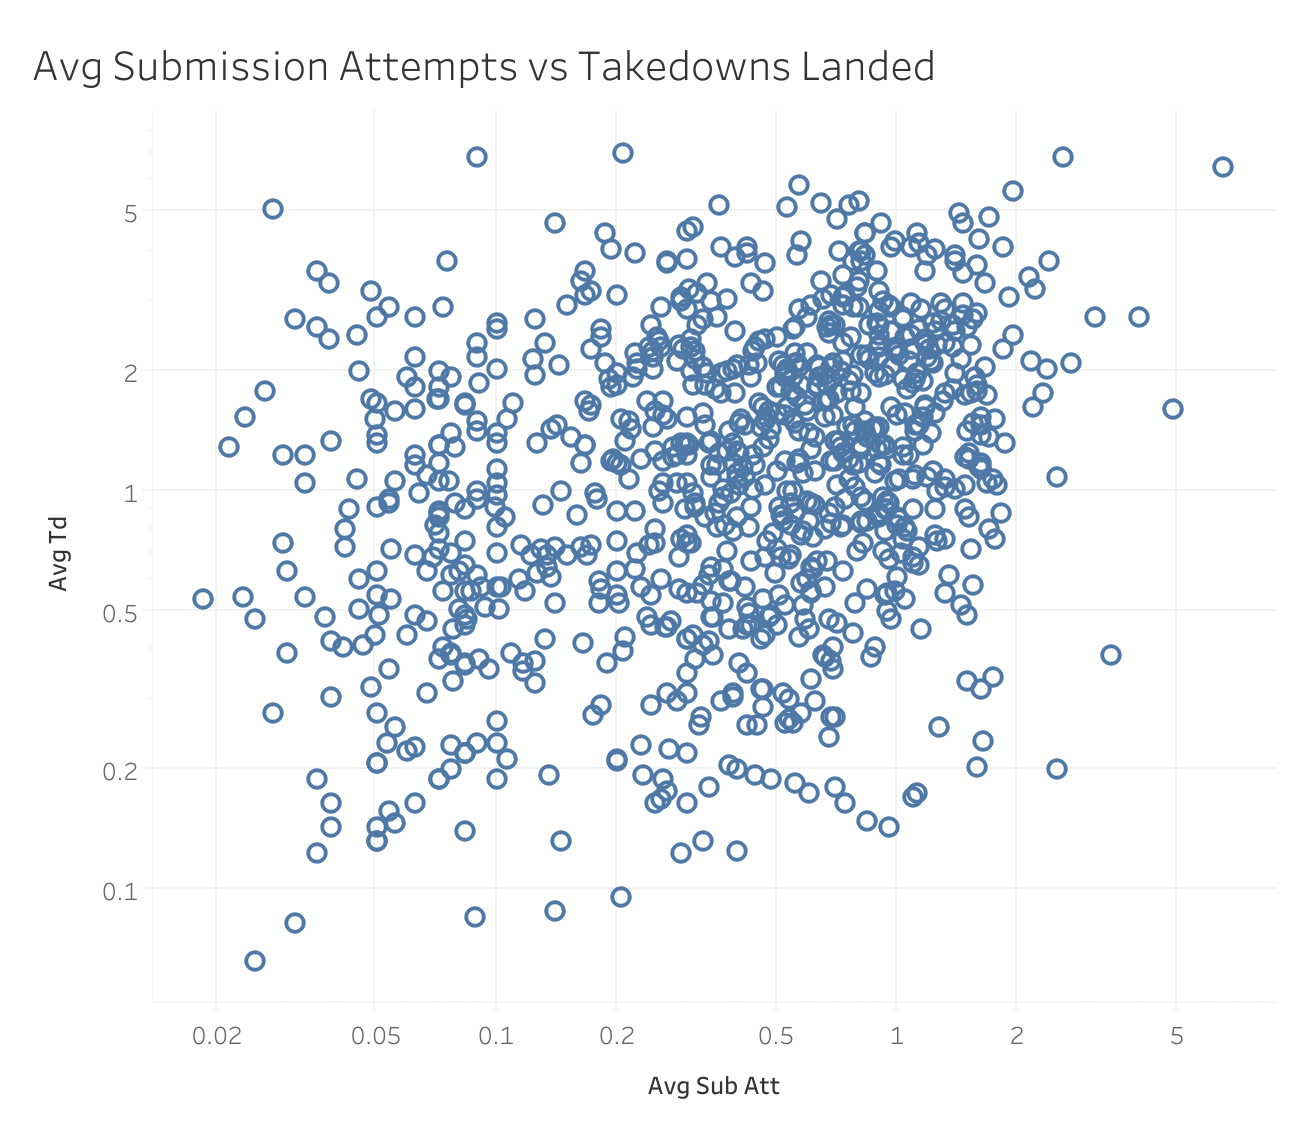

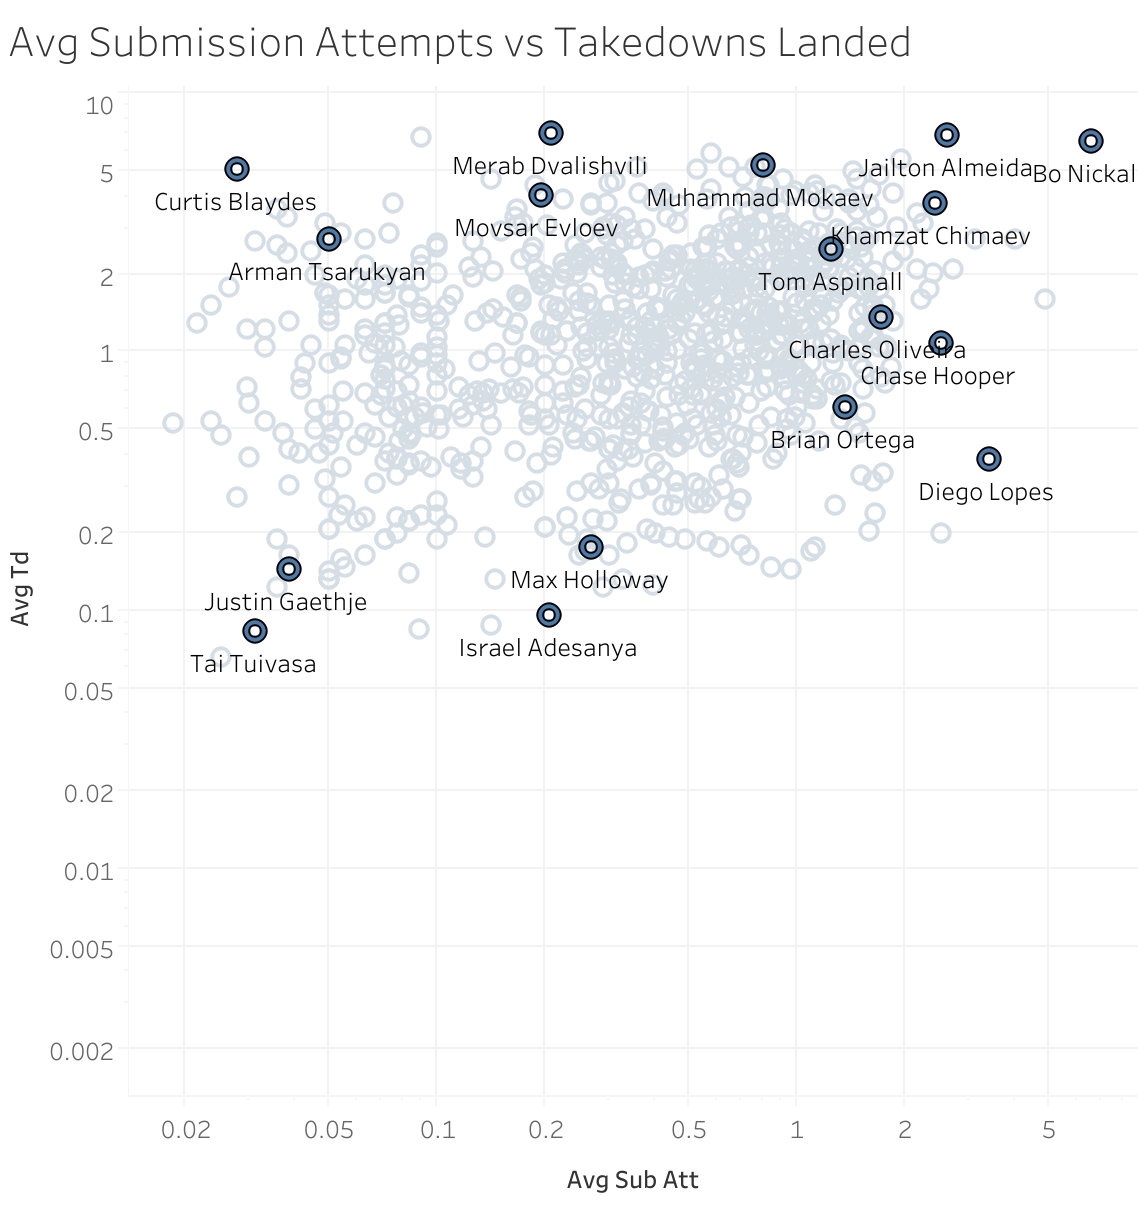

In the top right, we can see fighters well-regarded as elite overall grapplers - Bo Nickal, Khamzat Chimaev, Charles Oliveria, etc. Closer to the top left, we see fighters that oftentimes get flack for being "boring" and not attempting submissions - Merab Dvalishvili, Movsar Evloev, Muhammad Mokaev, etc. We also see near the bottom left our strikers, who not only rarely shoot takedowns, but also aren't looking to submit their opponent.
